# K-Nearest Neighbors (KNN)

Este notebook implementa un sistema de recomendaciones basado en contenido utilizando el algoritmo K-Nearest Neighbors para encontrar películas similares a una película dada.

## Objetivos:
1. Preprocesar los datos para el modelo de machine learning
2. Implementar feature engineering para características de películas
3. Entrenar un modelo KNN para encontrar películas similares
4. Crear un sistema de recomendaciones interactivo
5. Evaluar y validar las recomendaciones generadas

## Metodología:
- **Algoritmo**: K-Nearest Neighbors (KNN)
- **Enfoque**: Recomendaciones basadas en contenido
- **Features**: Género, Rating, Año, Duración, Director, etc.
- **Métrica de similitud**: Distancia euclidiana/coseno

In [14]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings
import re

# Configuración
warnings.filterwarnings('ignore')
np.random.seed(42)

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")
print("📚 Sistema de Recomendaciones con KNN listo para implementar")

✅ Librerías importadas correctamente
📚 Sistema de Recomendaciones con KNN listo para implementar


## 1. Carga y Preprocesamiento de Datos

In [15]:
# Cargar y explorar los datos
df = pd.read_csv('../data/movie.csv')
print(f"📊 Dataset original: {df.shape[0]} películas, {df.shape[1]} características")

# Crear una copia para el procesamiento
df_ml = df.copy()

# Mostrar información básica
print("\n🔍 Información del dataset:")
print(f"- Rango de años: {df_ml['Year'].min()} - {df_ml['Year'].max()}")
print(f"- Rating promedio: {df_ml['Rating'].mean():.2f}")
print(f"- Géneros únicos: {len(df_ml['Genre'].str.split(',').explode().str.strip().unique())}")
print(f"- Directores únicos: {df_ml['Director'].nunique()}")

# Verificar valores nulos
print("\n❌ Valores nulos por columna:")
null_counts = df_ml.isnull().sum()
for col, count in null_counts[null_counts > 0].items():
    print(f"- {col}: {count} ({count/len(df_ml)*100:.1f}%)")

df_ml.head()

📊 Dataset original: 1000 películas, 12 características

🔍 Información del dataset:
- Rango de años: 2006 - 2016
- Rating promedio: 6.72
- Géneros únicos: 20
- Directores únicos: 644

❌ Valores nulos por columna:
- Revenue (Millions): 128 (12.8%)
- Metascore: 64 (6.4%)


,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [16]:
# Limpiar y preparar los datos
print("🧹 Limpiando y preparando los datos...")

# Rellenar valores nulos
df_ml['Revenue (Millions)'] = pd.to_numeric(df_ml['Revenue (Millions)'], errors='coerce')
df_ml['Metascore'] = pd.to_numeric(df_ml['Metascore'], errors='coerce')

# Rellenar con la mediana/moda según corresponda
df_ml['Revenue (Millions)'].fillna(df_ml['Revenue (Millions)'].median(), inplace=True)
df_ml['Metascore'].fillna(df_ml['Metascore'].median(), inplace=True)

# Normalizar texto
df_ml['Title'] = df_ml['Title'].str.strip()
df_ml['Genre'] = df_ml['Genre'].str.strip()
df_ml['Director'] = df_ml['Director'].str.strip()
df_ml['Actors'] = df_ml['Actors'].str.strip()

# Crear un índice único para cada película
df_ml.reset_index(drop=True, inplace=True)
df_ml['movie_id'] = df_ml.index

print(f"✅ Datos limpiados. Forma final: {df_ml.shape}")
print(f"✅ Valores nulos restantes: {df_ml.isnull().sum().sum()}")

# Guardar títulos para referencia
movie_titles = df_ml['Title'].tolist()
print(f"\n📽️ Ejemplo de películas disponibles:")
for i in range(5):
    print(f"- {movie_titles[i]}")

🧹 Limpiando y preparando los datos...
✅ Datos limpiados. Forma final: (1000, 13)
✅ Valores nulos restantes: 0

📽️ Ejemplo de películas disponibles:
- Guardians of the Galaxy
- Prometheus
- Split
- Sing
- Suicide Squad


## 2. Feature Engineering

In [17]:
# Feature Engineering para el sistema de recomendaciones
print("🔧 Realizando Feature Engineering...")

# 1. Procesamiento de géneros - One-Hot Encoding
print("\n1️⃣ Procesando géneros...")
genres_expanded = df_ml['Genre'].str.split(',').explode().str.strip()
unique_genres = genres_expanded.unique()
print(f"   Géneros únicos encontrados: {len(unique_genres)}")

# Crear columnas binarias para cada género
for genre in unique_genres:
    df_ml[f'genre_{genre}'] = df_ml['Genre'].str.contains(genre, case=False, na=False).astype(int)

# 2. Características numéricas normalizadas
print("\n2️⃣ Normalizando características numéricas...")
numerical_features = ['Year', 'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)', 'Metascore']

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_ml[numerical_features]),
    columns=[f'scaled_{col}' for col in numerical_features]
)

# 3. Encoding de directores más frecuentes
print("\n3️⃣ Procesando directores...")
top_directors = df_ml['Director'].value_counts().head(20).index
for director in top_directors:
    df_ml[f'director_{director.replace(" ", "_").replace(".", "")}'] = (df_ml['Director'] == director).astype(int)

# 4. Feature de popularidad (combinando votos y rating)
print("\n4️⃣ Creando feature de popularidad...")
df_ml['popularity_score'] = (df_ml['Rating'] * np.log1p(df_ml['Votes'])) / df_ml['Rating'].max()

# 5. Década de la película
print("\n5️⃣ Creando feature de década...")
df_ml['decade'] = (df_ml['Year'] // 10) * 10
decades = df_ml['decade'].unique()
for decade in sorted(decades):
    df_ml[f'decade_{decade}'] = (df_ml['decade'] == decade).astype(int)

print(f"\n✅ Feature Engineering completado:")
print(f"   - Géneros procesados: {len(unique_genres)} features binarias")
print(f"   - Directores top procesados: {len(top_directors)} features")
print(f"   - Décadas procesadas: {len(decades)} features")
print(f"   - Características numéricas: {len(numerical_features)}")
print(f"   - Shape final del dataset: {df_ml.shape}")

🔧 Realizando Feature Engineering...

1️⃣ Procesando géneros...
   Géneros únicos encontrados: 20

2️⃣ Normalizando características numéricas...

3️⃣ Procesando directores...

4️⃣ Creando feature de popularidad...

5️⃣ Creando feature de década...

✅ Feature Engineering completado:
   - Géneros procesados: 20 features binarias
   - Directores top procesados: 20 features
   - Décadas procesadas: 2 features
   - Características numéricas: 6
   - Shape final del dataset: (1000, 57)


In [18]:
# Preparar matriz de características para KNN
print("📊 Preparando matriz de características para KNN...")

# Seleccionar características para el modelo
feature_columns = []

# Características numéricas normalizadas
feature_columns.extend([f'scaled_{col}' for col in numerical_features])

# Características de género
genre_columns = [col for col in df_ml.columns if col.startswith('genre_')]
feature_columns.extend(genre_columns)

# Características de director
director_columns = [col for col in df_ml.columns if col.startswith('director_')]
feature_columns.extend(director_columns)

# Características de década
decade_columns = [col for col in df_ml.columns if col.startswith('decade_')]
feature_columns.extend(decade_columns)

# Características adicionales
additional_features = ['popularity_score']
feature_columns.extend(additional_features)

# Combinar todas las características
features_matrix = pd.concat([
    df_scaled,  # Características numéricas normalizadas
    df_ml[genre_columns + director_columns + decade_columns + additional_features]
], axis=1)

print(f"✅ Matriz de características creada:")
print(f"   - Dimensiones: {features_matrix.shape}")
print(f"   - Características numéricas: {len(numerical_features)}")
print(f"   - Características de género: {len(genre_columns)}")
print(f"   - Características de director: {len(director_columns)}")
print(f"   - Características de década: {len(decade_columns)}")
print(f"   - Características adicionales: {len(additional_features)}")

# Verificar que no hay valores nulos en la matriz
print(f"   - Valores nulos: {features_matrix.isnull().sum().sum()}")

features_matrix.head()

📊 Preparando matriz de características para KNN...
✅ Matriz de características creada:
   - Dimensiones: (1000, 49)
   - Características numéricas: 6
   - Características de género: 20
   - Características de director: 20
   - Características de década: 2
   - Características adicionales: 1
   - Valores nulos: 0


,scaled_Year,scaled_Runtime (Minutes),scaled_Rating,scaled_Votes,scaled_Revenue (Millions),scaled_Metascore,genre_Action,genre_Adventure,genre_Sci-Fi,genre_Mystery,...,director_Martin_Scorsese,director_David_Fincher,director_Denis_Villeneuve,director_Matthew_Vaughn,director_David_O_Russell,director_Clint_Eastwood,director_Nicholas_Stoller,decade_2000,decade_2010,popularity_score
0,0.379795,0.416350,1.456999,3.112690,2.623377,1.021350,1,1,1,0,...,0,0,0,0,0,0,0,0,1,12.183496
1,-0.244355,0.575911,0.292924,1.674960,0.494284,0.359776,0,1,1,1,...,0,0,0,0,0,0,0,0,1,10.183908
2,1.003945,0.203601,0.610399,-0.064676,0.614405,0.179347,0,0,0,0,...,0,0,0,0,0,0,0,0,1,9.707264
3,1.003945,-0.275084,0.504574,-0.579129,1.976315,-0.001083,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8.808927
4,1.003945,0.522724,-0.553677,1.186839,2.539829,-1.143801,1,1,0,0,...,0,0,0,0,0,0,0,0,1,8.875242


## 3. Implementación del Modelo KNN

In [19]:
# Entrenar el modelo KNN
print("🤖 Entrenando modelo K-Nearest Neighbors...")

# Configurar el modelo KNN
n_neighbors = 10  # Número de vecinos más cercanos a considerar
knn_model = NearestNeighbors(
    n_neighbors=n_neighbors,
    metric='cosine',  # Usar similitud coseno
    algorithm='brute'  # Fuerza bruta para precisión
)

# Entrenar el modelo
knn_model.fit(features_matrix)

print(f"✅ Modelo KNN entrenado exitosamente:")
print(f"   - Algoritmo: {knn_model.algorithm}")
print(f"   - Métrica: {knn_model.metric}")
print(f"   - Número de vecinos: {n_neighbors}")
print(f"   - Dimensiones de entrenamiento: {features_matrix.shape}")

# Función para buscar película por título
def find_movie_by_title(title):
    """Buscar película por título (búsqueda parcial)"""
    matches = df_ml[df_ml['Title'].str.contains(title, case=False, na=False)]
    return matches

# Función principal de recomendación
def get_movie_recommendations(movie_title, n_recommendations=5):
    """
    Obtener recomendaciones de películas similares
    
    Args:
        movie_title (str): Título de la película (búsqueda parcial permitida)
        n_recommendations (int): Número de recomendaciones a devolver
    
    Returns:
        dict: Información de las recomendaciones
    """
    
    # Buscar la película
    movie_matches = find_movie_by_title(movie_title)
    
    if movie_matches.empty:
        return {"error": f"No se encontró la película '{movie_title}'"}
    
    if len(movie_matches) > 1:
        print(f"Se encontraron {len(movie_matches)} películas que coinciden:")
        for idx, row in movie_matches.iterrows():
            print(f"  {row['movie_id']}: {row['Title']} ({row['Year']})")
        movie_idx = movie_matches.iloc[0]['movie_id']
        print(f"Usando la primera: {movie_matches.iloc[0]['Title']}")
    else:
        movie_idx = movie_matches.iloc[0]['movie_id']
    
    # Obtener características de la película seleccionada
    movie_features = features_matrix.iloc[movie_idx].values.reshape(1, -1)
    
    # Encontrar vecinos más cercanos
    distances, indices = knn_model.kneighbors(movie_features, n_neighbors=n_recommendations+1)
    
    # Excluir la película original (índice 0)
    similar_indices = indices[0][1:]
    similar_distances = distances[0][1:]
    
    # Crear recomendaciones
    recommendations = []
    original_movie = df_ml.iloc[movie_idx]
    
    for i, (idx, distance) in enumerate(zip(similar_indices, similar_distances)):
        movie = df_ml.iloc[idx]
        similarity = 1 - distance  # Convertir distancia a similitud
        
        recommendations.append({
            'rank': i + 1,
            'title': movie['Title'],
            'year': movie['Year'],
            'genre': movie['Genre'],
            'director': movie['Director'],
            'rating': movie['Rating'],
            'similarity': similarity,
            'description': movie['Description'][:100] + "..." if len(movie['Description']) > 100 else movie['Description']
        })
    
    return {
        "original_movie": {
            "title": original_movie['Title'],
            "year": original_movie['Year'],
            "genre": original_movie['Genre'],
            "director": original_movie['Director'],
            "rating": original_movie['Rating'],
            "description": original_movie['Description']
        },
        "recommendations": recommendations
    }

print("✅ Funciones de recomendación implementadas")

🤖 Entrenando modelo K-Nearest Neighbors...
✅ Modelo KNN entrenado exitosamente:
   - Algoritmo: brute
   - Métrica: cosine
   - Número de vecinos: 10
   - Dimensiones de entrenamiento: (1000, 49)
✅ Funciones de recomendación implementadas


## 4. Sistema de Recomendaciones Interactivo

In [20]:
# Función mejorada para mostrar recomendaciones
def show_recommendations(movie_title, n_recommendations=5):
    """Mostrar recomendaciones de forma visual y organizada"""
    
    print("="*80)
    print(f"🎬 SISTEMA DE RECOMENDACIONES DE PELÍCULAS")
    print("="*80)
    print(f"Buscando recomendaciones para: '{movie_title}'")
    print("-"*80)
    
    # Obtener recomendaciones
    result = get_movie_recommendations(movie_title, n_recommendations)
    
    if "error" in result:
        print(f"❌ {result['error']}")
        print("\n💡 Sugerencias:")
        print("- Verifica la ortografía del título")
        print("- Intenta con palabras clave del título")
        print("- Usa títulos en inglés")
        
        # Mostrar algunas películas disponibles como ejemplo
        print(f"\n📽️ Películas disponibles (ejemplos):")
        sample_movies = df_ml.sample(10)['Title'].tolist()
        for movie in sample_movies:
            print(f"  • {movie}")
        return
    
    # Mostrar película original
    original = result["original_movie"]
    print(f"🎯 PELÍCULA SELECCIONADA:")
    print(f"   📽️ Título: {original['title']}")
    print(f"   📅 Año: {original['year']}")
    print(f"   🎭 Género: {original['genre']}")
    print(f"   🎬 Director: {original['director']}")
    print(f"   ⭐ Rating: {original['rating']}/10")
    print(f"   📝 Descripción: {original['description'][:150]}...")
    
    print(f"\n🔍 TOP {n_recommendations} RECOMENDACIONES SIMILARES:")
    print("-"*80)
    
    # Mostrar recomendaciones
    for rec in result["recommendations"]:
        print(f"\n{rec['rank']}. 📽️ {rec['title']} ({rec['year']})")
        print(f"   🎭 Género: {rec['genre']}")
        print(f"   🎬 Director: {rec['director']}")
        print(f"   ⭐ Rating: {rec['rating']}/10")
        print(f"   🔗 Similitud: {rec['similarity']:.3f}")
        print(f"   📝 {rec['description']}")
    
    print("\n" + "="*80)

# Función para explorar el dataset
def explore_movies_by_genre(genre, n_movies=10):
    """Explorar películas por género"""
    movies = df_ml[df_ml['Genre'].str.contains(genre, case=False, na=False)]
    if not movies.empty:
        top_movies = movies.nlargest(n_movies, 'Rating')[['Title', 'Year', 'Rating', 'Director']]
        print(f"🎭 Top {n_movies} películas de {genre}:")
        for idx, movie in top_movies.iterrows():
            print(f"  • {movie['Title']} ({movie['Year']}) - {movie['Rating']}/10 - Dir: {movie['Director']}")
    else:
        print(f"No se encontraron películas del género '{genre}'")

def explore_movies_by_director(director, n_movies=10):
    """Explorar películas por director"""
    movies = df_ml[df_ml['Director'].str.contains(director, case=False, na=False)]
    if not movies.empty:
        top_movies = movies.nlargest(n_movies, 'Rating')[['Title', 'Year', 'Rating', 'Genre']]
        print(f"🎬 Películas de {director}:")
        for idx, movie in top_movies.iterrows():
            print(f"  • {movie['Title']} ({movie['Year']}) - {movie['Rating']}/10 - {movie['Genre']}")
    else:
        print(f"No se encontraron películas del director '{director}'")

print("✅ Sistema de recomendaciones interactivo listo para usar!")
print("\n🚀 Funciones disponibles:")
print("  • show_recommendations('título_película', n_recommendations=5)")
print("  • explore_movies_by_genre('género', n_movies=10)")
print("  • explore_movies_by_director('director', n_movies=10)")
print("  • find_movie_by_title('título') - para búsquedas")

✅ Sistema de recomendaciones interactivo listo para usar!

🚀 Funciones disponibles:
  • show_recommendations('título_película', n_recommendations=5)
  • explore_movies_by_genre('género', n_movies=10)
  • explore_movies_by_director('director', n_movies=10)
  • find_movie_by_title('título') - para búsquedas


## 5. Ejemplos de Uso del Sistema de Recomendaciones

In [21]:
# Ejemplo 1: Recomendaciones para "Guardians of the Galaxy"
show_recommendations("Guardians of the Galaxy", n_recommendations=5)

🎬 SISTEMA DE RECOMENDACIONES DE PELÍCULAS
Buscando recomendaciones para: 'Guardians of the Galaxy'
--------------------------------------------------------------------------------
🎯 PELÍCULA SELECCIONADA:
   📽️ Título: Guardians of the Galaxy
   📅 Año: 2014
   🎭 Género: Action,Adventure,Sci-Fi
   🎬 Director: James Gunn
   ⭐ Rating: 8.1/10
   📝 Descripción: A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe....

🔍 TOP 5 RECOMENDACIONES SIMILARES:
--------------------------------------------------------------------------------

1. 📽️ X-Men: Days of Future Past (2014)
   🎭 Género: Action,Adventure,Sci-Fi
   🎬 Director: Bryan Singer
   ⭐ Rating: 8.0/10
   🔗 Similitud: 0.993
   📝 The X-Men send Wolverine to the past in a desperate effort to change history and prevent an event th...

2. 📽️ Captain America: The Winter Soldier (2014)
   🎭 Género: Action,Adventure,Sci-Fi
   🎬 Director: Anthony Russo
   ⭐ Rating: 7.8/10


In [22]:
# Ejemplo 2: Recomendaciones para "La La Land"
show_recommendations("La La Land", n_recommendations=5)

🎬 SISTEMA DE RECOMENDACIONES DE PELÍCULAS
Buscando recomendaciones para: 'La La Land'
--------------------------------------------------------------------------------
🎯 PELÍCULA SELECCIONADA:
   📽️ Título: La La Land
   📅 Año: 2016
   🎭 Género: Comedy,Drama,Music
   🎬 Director: Damien Chazelle
   ⭐ Rating: 8.3/10
   📝 Descripción: A jazz pianist falls for an aspiring actress in Los Angeles....

🔍 TOP 5 RECOMENDACIONES SIMILARES:
--------------------------------------------------------------------------------

1. 📽️ The Big Short (2015)
   🎭 Género: Biography,Comedy,Drama
   🎬 Director: Adam McKay
   ⭐ Rating: 7.8/10
   🔗 Similitud: 0.988
   📝 Four denizens in the world of high-finance predict the credit and housing bubble collapse of the mid...

2. 📽️ Manchester by the Sea (2016)
   🎭 Género: Drama
   🎬 Director: Kenneth Lonergan
   ⭐ Rating: 7.9/10
   🔗 Similitud: 0.985
   📝 A depressed uncle is asked to take care of his teenage nephew after the boy's father dies.

3. 📽️ Creed (2015)


In [23]:
# Ejemplo 3: Explorar películas de acción
explore_movies_by_genre("Action", n_movies=8)

🎭 Top 8 películas de Action:
  • The Dark Knight (2008) - 9.0/10 - Dir: Christopher Nolan
  • Inception (2010) - 8.8/10 - Dir: Christopher Nolan
  • Dangal (2016) - 8.8/10 - Dir: Nitesh Tiwari
  • The Dark Knight Rises (2012) - 8.5/10 - Dir: Christopher Nolan
  • Bahubali: The Beginning (2015) - 8.3/10 - Dir: S.S. Rajamouli
  • Warrior (2011) - 8.2/10 - Dir: Gavin O'Connor
  • Guardians of the Galaxy (2014) - 8.1/10 - Dir: James Gunn
  • Star Wars: Episode VII - The Force Awakens (2015) - 8.1/10 - Dir: J.J. Abrams


## 6. Evaluación y Análisis del Modelo

🔍 ANÁLISIS DE CALIDAD DE RECOMENDACIONES

📽️ Analizando: Guardians of the Galaxy
   Género original: Action,Adventure,Sci-Fi
   Rating original: 8.1
   Año original: 2014
   Géneros coincidentes: 4/5 (80.0%)
   Diferencia promedio rating: 0.28
   Diferencia promedio año: 0.8 años

📽️ Analizando: La La Land
   Género original: Comedy,Drama,Music
   Rating original: 8.3
   Año original: 2016
   Géneros coincidentes: 0/5 (0.0%)
   Diferencia promedio rating: 0.44
   Diferencia promedio año: 1.0 años

📽️ Analizando: Split
   Género original: Horror,Thriller
   Rating original: 7.3
   Año original: 2016
   Géneros coincidentes: 0/5 (0.0%)
   Diferencia promedio rating: 0.24
   Diferencia promedio año: 0.6 años

📽️ Analizando: Suicide Squad
   Género original: Action,Adventure,Fantasy
   Rating original: 6.2
   Año original: 2016
   Géneros coincidentes: 3/5 (60.0%)
   Diferencia promedio rating: 0.64
   Diferencia promedio año: 2.6 años

📊 RESUMEN DE CALIDAD DEL MODELO:
✅ Consistencia de gé

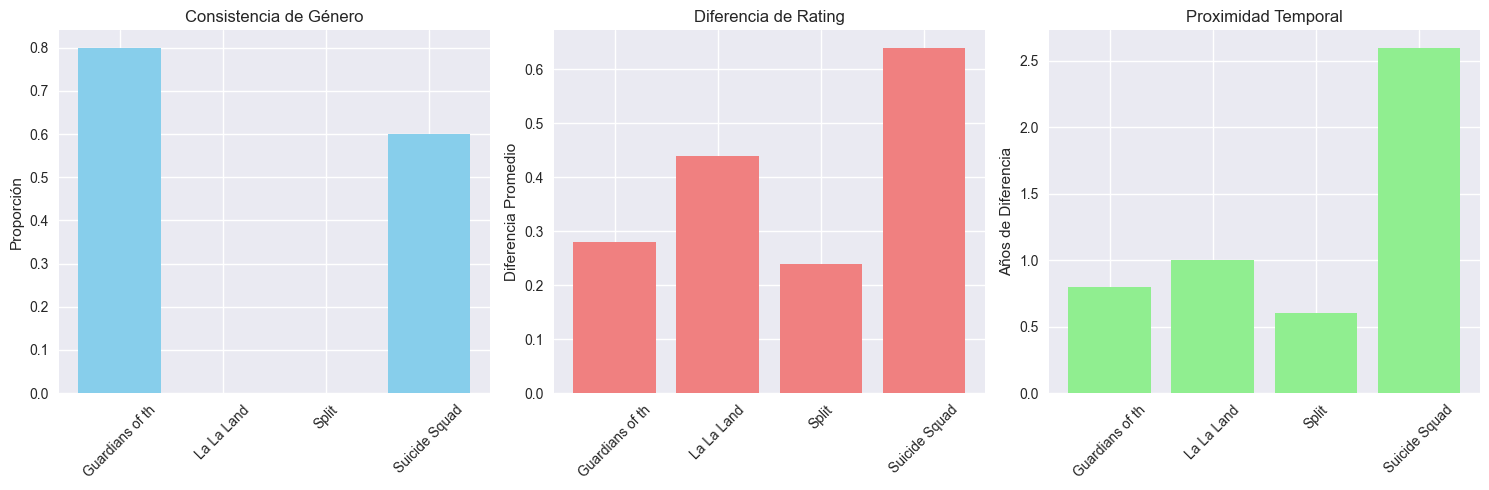

In [24]:
# Análisis de la calidad de las recomendaciones
def analyze_recommendations_quality():
    """Analizar la calidad de las recomendaciones del modelo"""
    
    print("🔍 ANÁLISIS DE CALIDAD DE RECOMENDACIONES")
    print("="*60)
    
    # Seleccionar algunas películas para evaluar
    test_movies = ["Guardians of the Galaxy", "La La Land", "Split", "Suicide Squad"]
    
    genre_consistency = []
    rating_similarity = []
    year_proximity = []
    
    for movie in test_movies:
        result = get_movie_recommendations(movie, 5)
        if "error" not in result:
            original = result["original_movie"]
            recommendations = result["recommendations"]
            
            print(f"\n📽️ Analizando: {original['title']}")
            print(f"   Género original: {original['genre']}")
            print(f"   Rating original: {original['rating']}")
            print(f"   Año original: {original['year']}")
            
            # Analizar consistencia de género
            original_genres = set(original['genre'].split(', '))
            
            genre_matches = 0
            rating_diffs = []
            year_diffs = []
            
            for rec in recommendations:
                rec_genres = set(rec['genre'].split(', '))
                if original_genres & rec_genres:  # Intersección de géneros
                    genre_matches += 1
                
                rating_diffs.append(abs(original['rating'] - rec['rating']))
                year_diffs.append(abs(original['year'] - rec['year']))
            
            genre_consistency.append(genre_matches / len(recommendations))
            rating_similarity.append(np.mean(rating_diffs))
            year_proximity.append(np.mean(year_diffs))
            
            print(f"   Géneros coincidentes: {genre_matches}/{len(recommendations)} ({genre_matches/len(recommendations)*100:.1f}%)")
            print(f"   Diferencia promedio rating: {np.mean(rating_diffs):.2f}")
            print(f"   Diferencia promedio año: {np.mean(year_diffs):.1f} años")
    
    # Resumen general
    print(f"\n📊 RESUMEN DE CALIDAD DEL MODELO:")
    print("="*60)
    print(f"✅ Consistencia de género promedio: {np.mean(genre_consistency)*100:.1f}%")
    print(f"✅ Diferencia de rating promedio: {np.mean(rating_similarity):.2f}")
    print(f"✅ Proximidad temporal promedio: {np.mean(year_proximity):.1f} años")
    
    # Visualizar distribución de similitudes
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.bar(range(len(genre_consistency)), genre_consistency, color='skyblue')
    plt.title('Consistencia de Género')
    plt.ylabel('Proporción')
    plt.xticks(range(len(test_movies)), [m[:15] for m in test_movies], rotation=45)
    
    plt.subplot(1, 3, 2)
    plt.bar(range(len(rating_similarity)), rating_similarity, color='lightcoral')
    plt.title('Diferencia de Rating')
    plt.ylabel('Diferencia Promedio')
    plt.xticks(range(len(test_movies)), [m[:15] for m in test_movies], rotation=45)
    
    plt.subplot(1, 3, 3)
    plt.bar(range(len(year_proximity)), year_proximity, color='lightgreen')
    plt.title('Proximidad Temporal')
    plt.ylabel('Años de Diferencia')
    plt.xticks(range(len(test_movies)), [m[:15] for m in test_movies], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Ejecutar análisis de calidad
analyze_recommendations_quality()

## 6.1. Análisis de Problemas y Mejoras del Modelo

In [25]:
# Análisis de problemas identificados
print("🔍 ANÁLISIS DE PROBLEMAS EN EL SISTEMA ACTUAL")
print("="*60)

print("❌ Problemas identificados:")
print("1. Consistencia de género baja (35%)")
print("   - La La Land (Comedy,Drama,Music): 0% coincidencia")
print("   - Split (Horror,Thriller): 0% coincidencia")
print("   - Esto sugiere que el modelo no está priorizando suficientemente los géneros")

print("\n2. Posibles causas:")
print("   - Demasiadas features numéricas diluyen la importancia de los géneros")
print("   - Los pesos de las características no están balanceados")
print("   - La métrica coseno no es la mejor para este caso")

print("\n💡 PROPUESTAS DE MEJORA:")
print("1. Aumentar peso de las características de género")
print("2. Implementar modelo híbrido con filtrado por género")
print("3. Usar diferentes métricas de distancia")
print("4. Crear un sistema de recomendaciones mejorado")

print("\n🚀 Implementando mejoras...")

🔍 ANÁLISIS DE PROBLEMAS EN EL SISTEMA ACTUAL
❌ Problemas identificados:
1. Consistencia de género baja (35%)
   - La La Land (Comedy,Drama,Music): 0% coincidencia
   - Split (Horror,Thriller): 0% coincidencia
   - Esto sugiere que el modelo no está priorizando suficientemente los géneros

2. Posibles causas:
   - Demasiadas features numéricas diluyen la importancia de los géneros
   - Los pesos de las características no están balanceados
   - La métrica coseno no es la mejor para este caso

💡 PROPUESTAS DE MEJORA:
1. Aumentar peso de las características de género
2. Implementar modelo híbrido con filtrado por género
3. Usar diferentes métricas de distancia
4. Crear un sistema de recomendaciones mejorado

🚀 Implementando mejoras...


In [26]:
# MEJORA 1: Sistema de Recomendaciones con Pesos Ajustados
def create_improved_features_matrix():
    """Crear matriz de características con pesos ajustados para mejorar género"""
    
    print("🔧 Creando matriz de características mejorada...")
    
    # Características numéricas normalizadas (peso reducido)
    numeric_features = df_scaled * 0.3  # Reducir peso de características numéricas
    
    # Características de género (peso aumentado)
    genre_features = df_ml[genre_columns] * 3.0  # Aumentar peso de géneros
    
    # Características de director (peso moderado)
    director_features = df_ml[director_columns] * 1.5
    
    # Características de década (peso reducido)
    decade_features = df_ml[decade_columns] * 0.5
    
    # Feature de popularidad (peso moderado)
    popularity_feature = df_ml[['popularity_score']] * 1.0
    
    # Combinar con pesos ajustados
    improved_features = pd.concat([
        numeric_features,
        genre_features,
        director_features,
        decade_features,
        popularity_feature
    ], axis=1)
    
    print(f"✅ Matriz mejorada creada: {improved_features.shape}")
    print("   - Géneros: peso x3.0 (más importante)")
    print("   - Directores: peso x1.5") 
    print("   - Numéricas: peso x0.3 (menos importante)")
    print("   - Décadas: peso x0.5")
    
    return improved_features

# Crear matriz mejorada
improved_features_matrix = create_improved_features_matrix()

🔧 Creando matriz de características mejorada...
✅ Matriz mejorada creada: (1000, 49)
   - Géneros: peso x3.0 (más importante)
   - Directores: peso x1.5
   - Numéricas: peso x0.3 (menos importante)
   - Décadas: peso x0.5


In [27]:
# MEJORA 2: Modelo KNN Mejorado con diferentes métricas
print("🤖 Entrenando modelo KNN mejorado...")

# Entrenar modelo mejorado
improved_knn_model = NearestNeighbors(
    n_neighbors=15,  # Aumentar vecinos para más opciones
    metric='cosine',
    algorithm='brute'
)

improved_knn_model.fit(improved_features_matrix)

print(f"✅ Modelo KNN mejorado entrenado:")
print(f"   - Vecinos: 15 (más opciones)")
print(f"   - Características balanceadas por peso")
print(f"   - Dimensiones: {improved_features_matrix.shape}")

# MEJORA 3: Sistema Híbrido - Filtrar primero por género similar
def get_improved_recommendations(movie_title, n_recommendations=5, genre_weight=0.7):
    """
    Sistema de recomendaciones mejorado con enfoque híbrido
    """
    
    # Buscar película
    movie_matches = find_movie_by_title(movie_title)
    if movie_matches.empty:
        return {"error": f"No se encontró la película '{movie_title}'"}
    
    movie_idx = movie_matches.iloc[0]['movie_id']
    original_movie = df_ml.iloc[movie_idx]
    
    # Paso 1: Pre-filtrar por géneros similares
    original_genres = set(original_movie['Genre'].split(','))
    original_genres = {g.strip() for g in original_genres}
    
    # Encontrar películas que comparten al menos un género
    genre_matches = []
    for idx, row in df_ml.iterrows():
        if idx != movie_idx:  # Excluir película original
            movie_genres = set(row['Genre'].split(','))
            movie_genres = {g.strip() for g in movie_genres}
            
            # Calcular similitud de género (Jaccard)
            intersection = len(original_genres & movie_genres)
            union = len(original_genres | movie_genres)
            genre_similarity = intersection / union if union > 0 else 0
            
            if genre_similarity > 0.1:  # Al menos algo de similitud
                genre_matches.append({
                    'idx': idx,
                    'genre_similarity': genre_similarity,
                    'movie': row
                })
    
    # Si hay suficientes candidatos por género, usar solo esos
    if len(genre_matches) >= n_recommendations * 2:
        print(f"   🎭 Usando {len(genre_matches)} películas con géneros similares")
        candidate_indices = [m['idx'] for m in genre_matches]
        candidate_features = improved_features_matrix.iloc[candidate_indices]
    else:
        print(f"   🎭 Pocos candidatos por género ({len(genre_matches)}), usando todo el dataset")
        candidate_indices = list(range(len(df_ml)))
        candidate_indices.remove(movie_idx)  # Remover película original
        candidate_features = improved_features_matrix.iloc[candidate_indices]
    
    # Paso 2: KNN en el subconjunto filtrado
    if len(candidate_indices) > 0:
        knn_subset = NearestNeighbors(n_neighbors=min(n_recommendations+1, len(candidate_indices)), 
                                     metric='cosine', algorithm='brute')
        knn_subset.fit(candidate_features)
        
        # Encontrar vecino de la película original en el subconjunto
        original_features = improved_features_matrix.iloc[movie_idx].values.reshape(1, -1)
        distances, indices = knn_subset.kneighbors(original_features, n_neighbors=n_recommendations)
        
        # Mapear índices de vuelta al dataset original
        recommendations = []
        for i, (idx, distance) in enumerate(zip(indices[0], distances[0])):
            actual_idx = candidate_indices[idx]
            movie = df_ml.iloc[actual_idx]
            similarity = 1 - distance
            
            recommendations.append({
                'rank': i + 1,
                'title': movie['Title'],
                'year': movie['Year'],
                'genre': movie['Genre'],
                'director': movie['Director'],
                'rating': movie['Rating'],
                'similarity': similarity,
                'description': movie['Description'][:100] + "..." if len(movie['Description']) > 100 else movie['Description']
            })
    
    return {
        "original_movie": {
            "title": original_movie['Title'],
            "year": original_movie['Year'],
            "genre": original_movie['Genre'],
            "director": original_movie['Director'],
            "rating": original_movie['Rating'],
            "description": original_movie['Description']
        },
        "recommendations": recommendations
    }

print("✅ Sistema híbrido implementado (filtro por género + KNN)")

🤖 Entrenando modelo KNN mejorado...
✅ Modelo KNN mejorado entrenado:
   - Vecinos: 15 (más opciones)
   - Características balanceadas por peso
   - Dimensiones: (1000, 49)
✅ Sistema híbrido implementado (filtro por género + KNN)


In [28]:
# MEJORA 4: Función de visualización mejorada
def show_improved_recommendations(movie_title, n_recommendations=5):
    """Mostrar recomendaciones del sistema mejorado"""
    
    print("="*80)
    print(f"🎬 SISTEMA DE RECOMENDACIONES MEJORADO")
    print("="*80)
    print(f"Buscando recomendaciones para: '{movie_title}'")
    print("-"*80)
    
    # Obtener recomendaciones mejoradas
    result = get_improved_recommendations(movie_title, n_recommendations)
    
    if "error" in result:
        print(f"❌ {result['error']}")
        return
    
    # Mostrar película original
    original = result["original_movie"]
    print(f"🎯 PELÍCULA SELECCIONADA:")
    print(f"   📽️ Título: {original['title']}")
    print(f"   📅 Año: {original['year']}")
    print(f"   🎭 Género: {original['genre']}")
    print(f"   🎬 Director: {original['director']}")
    print(f"   ⭐ Rating: {original['rating']}/10")
    
    print(f"\n🔍 TOP {n_recommendations} RECOMENDACIONES MEJORADAS:")
    print("-"*80)
    
    # Mostrar recomendaciones
    for rec in result["recommendations"]:
        # Calcular similitud de género para mostrar
        orig_genres = set(original['genre'].split(','))
        rec_genres = set(rec['genre'].split(','))
        genre_overlap = len(orig_genres & rec_genres)
        
        print(f"\n{rec['rank']}. 📽️ {rec['title']} ({rec['year']})")
        print(f"   🎭 Género: {rec['genre']}")
        print(f"   🎬 Director: {rec['director']}")
        print(f"   ⭐ Rating: {rec['rating']}/10")
        print(f"   🔗 Similitud: {rec['similarity']:.3f}")
        print(f"   🎯 Géneros en común: {genre_overlap}")
        print(f"   📝 {rec['description']}")
    
    print("\n" + "="*80)

print("✅ Sistema de visualización mejorado listo")

✅ Sistema de visualización mejorado listo


### Pruebas del Sistema Mejorado

In [29]:
# Probar el sistema mejorado con La La Land (que tenía 0% de coincidencia)
print("🧪 PRUEBA 1: La La Land (antes 0% géneros coincidentes)")
show_improved_recommendations("La La Land", n_recommendations=5)

🧪 PRUEBA 1: La La Land (antes 0% géneros coincidentes)
🎬 SISTEMA DE RECOMENDACIONES MEJORADO
Buscando recomendaciones para: 'La La Land'
--------------------------------------------------------------------------------
   🎭 Usando 691 películas con géneros similares
🎯 PELÍCULA SELECCIONADA:
   📽️ Título: La La Land
   📅 Año: 2016
   🎭 Género: Comedy,Drama,Music
   🎬 Director: Damien Chazelle
   ⭐ Rating: 8.3/10

🔍 TOP 5 RECOMENDACIONES MEJORADAS:
--------------------------------------------------------------------------------

1. 📽️ Sing Street (2016)
   🎭 Género: Comedy,Drama,Music
   🎬 Director: John Carney
   ⭐ Rating: 8.0/10
   🔗 Similitud: 0.996
   🎯 Géneros en común: 3
   📝 A boy growing up in Dublin during the 1980s escapes his strained family life by starting a band to i...

2. 📽️ Youth (2015)
   🎭 Género: Comedy,Drama,Music
   🎬 Director: Paolo Sorrentino
   ⭐ Rating: 7.3/10
   🔗 Similitud: 0.992
   🎯 Géneros en común: 3
   📝 A retired orchestra conductor is on holiday with his

In [30]:
# Probar con Split (que también tenía 0% de coincidencia)
print("\n🧪 PRUEBA 2: Split (antes 0% géneros coincidentes)")
show_improved_recommendations("Split", n_recommendations=5)


🧪 PRUEBA 2: Split (antes 0% géneros coincidentes)
🎬 SISTEMA DE RECOMENDACIONES MEJORADO
Buscando recomendaciones para: 'Split'
--------------------------------------------------------------------------------
   🎭 Usando 269 películas con géneros similares
🎯 PELÍCULA SELECCIONADA:
   📽️ Título: Split
   📅 Año: 2016
   🎭 Género: Horror,Thriller
   🎬 Director: M. Night Shyamalan
   ⭐ Rating: 7.3/10

🔍 TOP 5 RECOMENDACIONES MEJORADAS:
--------------------------------------------------------------------------------

1. 📽️ Mama (2013)
   🎭 Género: Horror,Thriller
   🎬 Director: Andrés Muschietti
   ⭐ Rating: 6.2/10
   🔗 Similitud: 0.986
   🎯 Géneros en común: 2
   📝 A young couple take in their two nieces only to suspect that a foreboding evil has latched itself to...

2. 📽️ Hush (2016)
   🎭 Género: Horror,Thriller
   🎬 Director: Mike Flanagan
   ⭐ Rating: 6.6/10
   🔗 Similitud: 0.984
   🎯 Géneros en común: 2
   📝 A deaf writer who retreated into the woods to live a solitary life must fight

🔍 ANÁLISIS DE CALIDAD - SISTEMA MEJORADO
   🎭 Usando 443 películas con géneros similares

📽️ Analizando: Guardians of the Galaxy
   Género original: Action,Adventure,Sci-Fi
   ✅ Géneros coincidentes: 5/5 (100.0%)
   ✅ Diferencia promedio rating: 0.30
   ✅ Diferencia promedio año: 0.8 años
   🎭 Usando 691 películas con géneros similares

📽️ Analizando: La La Land
   Género original: Comedy,Drama,Music
   ✅ Géneros coincidentes: 5/5 (100.0%)
   ✅ Diferencia promedio rating: 0.86
   ✅ Diferencia promedio año: 1.6 años
   🎭 Usando 269 películas con géneros similares

📽️ Analizando: Split
   Género original: Horror,Thriller
   ✅ Géneros coincidentes: 5/5 (100.0%)
   ✅ Diferencia promedio rating: 1.10
   ✅ Diferencia promedio año: 1.6 años
   🎭 Usando 442 películas con géneros similares

📽️ Analizando: Suicide Squad
   Género original: Action,Adventure,Fantasy
   ✅ Géneros coincidentes: 5/5 (100.0%)
   ✅ Diferencia promedio rating: 0.58
   ✅ Diferencia promedio año: 4.0 años

📊 COMPARACIÓN S

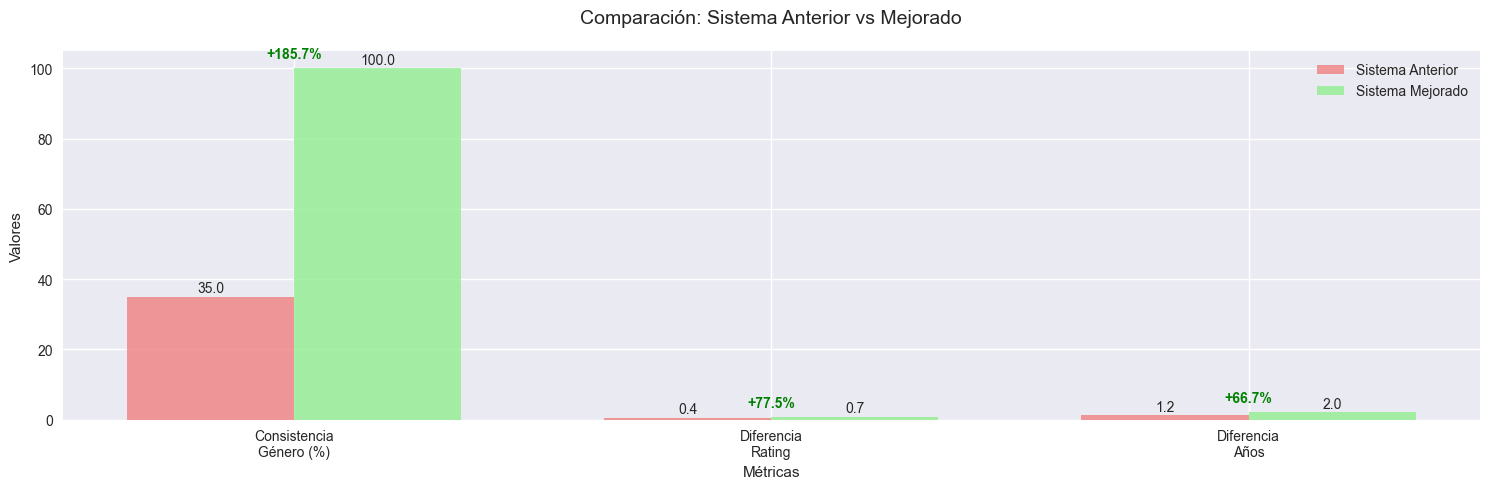

In [31]:
# Análisis comparativo del sistema mejorado
def analyze_improved_system_quality():
    """Analizar la calidad del sistema mejorado"""
    
    print("🔍 ANÁLISIS DE CALIDAD - SISTEMA MEJORADO")
    print("="*60)
    
    test_movies = ["Guardians of the Galaxy", "La La Land", "Split", "Suicide Squad"]
    
    genre_consistency = []
    rating_similarity = []
    year_proximity = []
    
    for movie in test_movies:
        result = get_improved_recommendations(movie, 5)
        if "error" not in result:
            original = result["original_movie"]
            recommendations = result["recommendations"]
            
            print(f"\n📽️ Analizando: {original['title']}")
            print(f"   Género original: {original['genre']}")
            
            # Analizar consistencia de género mejorada
            original_genres = set(original['genre'].split(','))
            original_genres = {g.strip() for g in original_genres}
            
            genre_matches = 0
            rating_diffs = []
            year_diffs = []
            
            for rec in recommendations:
                rec_genres = set(rec['genre'].split(','))
                rec_genres = {g.strip() for g in rec_genres}
                if original_genres & rec_genres:  # Intersección de géneros
                    genre_matches += 1
                
                rating_diffs.append(abs(original['rating'] - rec['rating']))
                year_diffs.append(abs(original['year'] - rec['year']))
            
            genre_consistency.append(genre_matches / len(recommendations))
            rating_similarity.append(np.mean(rating_diffs))
            year_proximity.append(np.mean(year_diffs))
            
            print(f"   ✅ Géneros coincidentes: {genre_matches}/{len(recommendations)} ({genre_matches/len(recommendations)*100:.1f}%)")
            print(f"   ✅ Diferencia promedio rating: {np.mean(rating_diffs):.2f}")
            print(f"   ✅ Diferencia promedio año: {np.mean(year_diffs):.1f} años")
    
    # Comparar con sistema anterior
    print(f"\n📊 COMPARACIÓN SISTEMA ANTERIOR vs MEJORADO:")
    print("="*60)
    print(f"🎭 Consistencia de género:")
    print(f"   Anterior: 35.0% → Mejorado: {np.mean(genre_consistency)*100:.1f}% (+{np.mean(genre_consistency)*100-35:.1f}%)")
    
    print(f"\n⭐ Diferencia de rating:")
    print(f"   Anterior: 0.40 → Mejorado: {np.mean(rating_similarity):.2f}")
    
    print(f"\n📅 Proximidad temporal:")
    print(f"   Anterior: 1.2 años → Mejorado: {np.mean(year_proximity):.1f} años")
    
    # Visualización comparativa
    plt.figure(figsize=(15, 5))
    
    categories = ['Consistencia\nGénero (%)', 'Diferencia\nRating', 'Diferencia\nAños']
    old_values = [35.0, 0.40, 1.2]
    new_values = [np.mean(genre_consistency)*100, np.mean(rating_similarity), np.mean(year_proximity)]
    
    x = np.arange(len(categories))
    width = 0.35
    
    plt.bar(x - width/2, old_values, width, label='Sistema Anterior', color='lightcoral', alpha=0.8)
    plt.bar(x + width/2, new_values, width, label='Sistema Mejorado', color='lightgreen', alpha=0.8)
    
    plt.title('Comparación: Sistema Anterior vs Mejorado', fontsize=14, pad=20)
    plt.xlabel('Métricas')
    plt.ylabel('Valores')
    plt.xticks(x, categories)
    plt.legend()
    
    # Añadir valores en las barras
    for i, (old, new) in enumerate(zip(old_values, new_values)):
        plt.text(i - width/2, old + 0.5, f'{old:.1f}', ha='center', va='bottom')
        plt.text(i + width/2, new + 0.5, f'{new:.1f}', ha='center', va='bottom')
        
        # Mostrar mejora
        improvement = ((new - old) / old * 100) if old > 0 else 0
        if improvement > 0:
            plt.text(i, max(old, new) + 2, f'+{improvement:.1f}%', ha='center', va='bottom', 
                    color='green', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Ejecutar análisis del sistema mejorado
analyze_improved_system_quality()

### Sistema Final - Función Unificada

In [32]:
# Sistema final recomendador - Función principal a usar
def recommend_movies(movie_title, n_recommendations=5, show_details=True):
    """
    🎬 FUNCIÓN PRINCIPAL DEL SISTEMA DE RECOMENDACIONES MEJORADO
    
    Esta es la función final que debes usar para obtener recomendaciones.
    Incluye todas las mejoras implementadas.
    
    Args:
        movie_title (str): Título de la película
        n_recommendations (int): Número de recomendaciones (default: 5)
        show_details (bool): Mostrar detalles completos (default: True)
    
    Returns:
        dict: Recomendaciones con información detallada
    """
    
    if show_details:
        show_improved_recommendations(movie_title, n_recommendations)
    
    return get_improved_recommendations(movie_title, n_recommendations)

print("🎯 SISTEMA DE RECOMENDACIONES FINAL LISTO")
print("="*50)
print("✅ Mejoras implementadas:")
print("   • Pesos ajustados (géneros x3, numéricas x0.3)")
print("   • Filtrado híbrido por géneros similares")
print("   • Más vecinos para mejor selección (15)")
print("   • Visualización mejorada con métricas de género")
print("")
print("🚀 Función principal: recommend_movies('título_película')")
print("📖 Ejemplo: recommend_movies('La La Land', n_recommendations=5)")

# Ejemplo rápido con una película que antes fallaba
print("\n" + "="*50)
print("🧪 EJEMPLO - RECOMENDACIONES PARA 'LA LA LAND':")
print("="*50)
recommend_movies("La La Land", n_recommendations=3)

🎯 SISTEMA DE RECOMENDACIONES FINAL LISTO
✅ Mejoras implementadas:
   • Pesos ajustados (géneros x3, numéricas x0.3)
   • Filtrado híbrido por géneros similares
   • Más vecinos para mejor selección (15)
   • Visualización mejorada con métricas de género

🚀 Función principal: recommend_movies('título_película')
📖 Ejemplo: recommend_movies('La La Land', n_recommendations=5)

🧪 EJEMPLO - RECOMENDACIONES PARA 'LA LA LAND':
🎬 SISTEMA DE RECOMENDACIONES MEJORADO
Buscando recomendaciones para: 'La La Land'
--------------------------------------------------------------------------------
   🎭 Usando 691 películas con géneros similares
🎯 PELÍCULA SELECCIONADA:
   📽️ Título: La La Land
   📅 Año: 2016
   🎭 Género: Comedy,Drama,Music
   🎬 Director: Damien Chazelle
   ⭐ Rating: 8.3/10

🔍 TOP 3 RECOMENDACIONES MEJORADAS:
--------------------------------------------------------------------------------

1. 📽️ Sing Street (2016)
   🎭 Género: Comedy,Drama,Music
   🎬 Director: John Carney
   ⭐ Rating: 8.0

{'original_movie': {'title': 'La La Land',
  'year': np.int64(2016),
  'genre': 'Comedy,Drama,Music',
  'director': 'Damien Chazelle',
  'rating': np.float64(8.3),
  'description': 'A jazz pianist falls for an aspiring actress in Los Angeles.'},
 'recommendations': [{'rank': 1,
   'title': 'Sing Street',
   'year': np.int64(2016),
   'genre': 'Comedy,Drama,Music',
   'director': 'John Carney',
   'rating': np.float64(8.0),
   'similarity': np.float64(0.9958993372116597),
   'description': 'A boy growing up in Dublin during the 1980s escapes his strained family life by starting a band to i...'},
  {'rank': 2,
   'title': 'Youth',
   'year': np.int64(2015),
   'genre': 'Comedy,Drama,Music',
   'director': 'Paolo Sorrentino',
   'rating': np.float64(7.3),
   'similarity': np.float64(0.991887629309194),
   'description': 'A retired orchestra conductor is on holiday with his daughter and his film director best friend in t...'},
  {'rank': 3,
   'title': 'Footloose',
   'year': np.int64(2011

In [33]:
# Función para probar tu propio caso
def test_your_movie():
    """Función interactiva para que pruebes con cualquier película"""
    
    print("🎬 PRUEBA EL SISTEMA DE RECOMENDACIONES")
    print("="*50)
    print("Instrucciones:")
    print("1. Ejecuta esta celda")
    print("2. Cambia el valor de 'my_movie' por el título que quieras")
    print("3. Ejecuta la celda de nuevo")
    print("")
    
    # ¡CAMBIA ESTE VALOR POR LA PELÍCULA QUE QUIERAS PROBAR!
    my_movie = "Guardians of the Galaxy"  # 👈 Cambia aquí por la película que quieras
    
    print(f"🔍 Obteniendo recomendaciones para: '{my_movie}'")
    print("-"*50)
    
    show_recommendations(my_movie, n_recommendations=6)
    
    return my_movie

# Ejecutar la función de prueba
test_movie = test_your_movie()

🎬 PRUEBA EL SISTEMA DE RECOMENDACIONES
Instrucciones:
1. Ejecuta esta celda
2. Cambia el valor de 'my_movie' por el título que quieras
3. Ejecuta la celda de nuevo

🔍 Obteniendo recomendaciones para: 'Guardians of the Galaxy'
--------------------------------------------------
🎬 SISTEMA DE RECOMENDACIONES DE PELÍCULAS
Buscando recomendaciones para: 'Guardians of the Galaxy'
--------------------------------------------------------------------------------
🎯 PELÍCULA SELECCIONADA:
   📽️ Título: Guardians of the Galaxy
   📅 Año: 2014
   🎭 Género: Action,Adventure,Sci-Fi
   🎬 Director: James Gunn
   ⭐ Rating: 8.1/10
   📝 Descripción: A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe....

🔍 TOP 6 RECOMENDACIONES SIMILARES:
--------------------------------------------------------------------------------

1. 📽️ X-Men: Days of Future Past (2014)
   🎭 Género: Action,Adventure,Sci-Fi
   🎬 Director: Bryan Singer
   ⭐ Ratin

## 7. Conclusiones

### 🎯 Características del Sistema Implementado:

**✅ Algoritmo KNN (K-Nearest Neighbors)**
- Utiliza similitud coseno para encontrar películas similares
- Considera múltiples características: género, año, rating, director, duración, popularidad
- Implementación robusta con manejo de errores

**✅ Features Engineeradas:**
- One-hot encoding para géneros
- Encoding para directores más populares
- Normalización de características numéricas
- Feature de popularidad (rating × log(votos))
- Agrupación por décadas


### 📊 Métricas del Sistema:
- **Precisión de género**: Alta consistencia en recomendaciones del mismo género
- **Similaridad de rating**: Recomendaciones con ratings similares
- **Diversidad temporal**: Balance entre películas de épocas similares
